<a href="https://colab.research.google.com/github/SandroMuradashvili/The-Visual-Storyteller/blob/main/data_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Setup & Dependencies
# Install required packages
!pip install torch torchvision timm transformers pillow matplotlib scikit-learn tqdm -q

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from collections import Counter
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
import timm

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [2]:
# 2. Data Loading & Preprocessing

# Download data from cloud
!pip install -q gdown

import gdown

file_id = "1st_oepUulGKCn5C1hvWvYYm87ftlUr6j"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "caption_data.zip", quiet=False)

# Extract the dataset
!unzip -q caption_data.zip

# Load captions
captions_df = pd.read_csv('captions.txt')
print(f"Total captions: {len(captions_df)}")
print(f"Unique images: {captions_df['image'].nunique()}")
print("\nSample:")
print(captions_df.head(10))

# Create vocabulary
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, captions):
        frequencies = Counter()
        idx = 4

        for caption in captions:
            tokens = self.tokenize(caption)
            frequencies.update(tokens)

        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

        print(f"Vocabulary size: {len(self.stoi)}")
        return self

    def tokenize(self, text):
        return text.lower().replace(',', '').replace('.', '').split()

    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

# Build vocabulary
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(captions_df['caption'].tolist())

# Save vocabulary
with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print("Vocabulary saved!")

# Split data: 80% train, 10% val, 10% test
unique_images = captions_df['image'].unique()
np.random.seed(42)
np.random.shuffle(unique_images)

train_size = int(0.8 * len(unique_images))
val_size = int(0.1 * len(unique_images))

train_images = unique_images[:train_size]
val_images = unique_images[train_size:train_size+val_size]
test_images = unique_images[train_size+val_size:]

print(f"Train images: {len(train_images)}")
print(f"Val images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

# Save splits
splits = {
    'train': train_images.tolist(),
    'val': val_images.tolist(),
    'test': test_images.tolist()
}
with open('data_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

Downloading...
From (original): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j
From (redirected): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j&confirm=t&uuid=fb88e0e0-01d9-4b6b-9e75-1ca5693e369f
To: /content/caption_data.zip
100%|██████████| 1.11G/1.11G [00:15<00:00, 73.3MB/s]


Total captions: 40455
Unique images: 8091

Sample:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each o

In [3]:
# 3. Dataset & DataLoader
class FlickrDataset(Dataset):
    def __init__(self, images_list, captions_df, vocab, img_dir, transform=None):
        self.images_list = images_list
        self.captions_df = captions_df[captions_df['image'].isin(images_list)]
        self.vocab = vocab
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        caption = self.captions_df.iloc[idx]['caption']
        img_name = self.captions_df.iloc[idx]['image']
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Numericalize caption
        numericalized = [self.vocab.stoi["<SOS>"]]
        numericalized += self.vocab.numericalize(caption)
        numericalized.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized)

# Collate function for batching
class CollateFunc:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)

        captions = [item[1] for item in batch]
        captions = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)

        return images, captions

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FlickrDataset(train_images, captions_df, vocab, 'Images', train_transform)
val_dataset = FlickrDataset(val_images, captions_df, vocab, 'Images', val_transform)
test_dataset = FlickrDataset(test_images, captions_df, vocab, 'Images', val_transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create dataloaders
batch_size = 32
pad_idx = vocab.stoi["<PAD>"]

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=CollateFunc(pad_idx),
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=CollateFunc(pad_idx),
    num_workers=2,
    pin_memory=True
)


Train samples: 32360
Val samples: 4045
Test samples: 4050


In [4]:
# 4. Model Architecture
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        # Use EfficientNet-B0 pretrained
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        # Remove classifier
        self.backbone.classifier = nn.Identity()

        # Get feature dimension (1280 for efficientnet_b0)
        backbone_dim = 1280

        # Project to embed_dim
        self.projection = nn.Linear(backbone_dim, embed_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, images):
        # Extract features
        features = self.backbone(images)  # [batch, 1280]
        features = self.projection(features)  # [batch, embed_dim]
        features = self.dropout(features)
        return features.unsqueeze(1)  # [batch, 1, embed_dim]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=2048,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, image_features, tgt_mask=None, tgt_padding_mask=None):
        # Embed captions
        embedded = self.embedding(captions) * np.sqrt(self.embed_dim)
        embedded = self.pos_encoding(embedded)
        embedded = self.dropout(embedded)

        # Decode
        output = self.transformer_decoder(
            tgt=embedded,
            memory=image_features,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )

        # Project to vocabulary
        output = self.fc_out(output)
        return output

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.decoder = TransformerDecoder(vocab_size, embed_dim, num_heads, num_layers, dropout)

    def forward(self, images, captions, tgt_mask=None, tgt_padding_mask=None):
        image_features = self.encoder(images)
        output = self.decoder(captions, image_features, tgt_mask, tgt_padding_mask)
        return output

# Create model
vocab_size = len(vocab.stoi)
model = ImageCaptioningModel(
    vocab_size=vocab_size,
    embed_dim=512,
    num_heads=8,
    num_layers=6,
    dropout=0.1
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


print("Model created!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total parameters: 32,965,687
Trainable parameters: 32,965,687
Model created!


Starting training...

Epoch 1/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  6.04it/s]


Train Loss: 3.4782 | Val Loss: 3.0146
✓ Best model saved! (Val Loss: 3.0146)

Epoch 2/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.72it/s]


Train Loss: 2.7826 | Val Loss: 2.8456
✓ Best model saved! (Val Loss: 2.8456)

Epoch 3/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.95it/s]


Train Loss: 2.5065 | Val Loss: 2.7557
✓ Best model saved! (Val Loss: 2.7557)

Epoch 4/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.70it/s]


Train Loss: 2.3197 | Val Loss: 2.7212
✓ Best model saved! (Val Loss: 2.7212)

Epoch 5/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  6.01it/s]


Train Loss: 2.1747 | Val Loss: 2.7373
Learning rate reduced: 3.00e-04 → 1.50e-04

Epoch 6/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.70it/s]


Train Loss: 1.8970 | Val Loss: 2.6805
✓ Best model saved! (Val Loss: 2.6805)

Epoch 7/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  6.04it/s]


Train Loss: 1.7629 | Val Loss: 2.7062
Learning rate reduced: 1.50e-04 → 7.50e-05

Epoch 8/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.67it/s]


Train Loss: 1.5708 | Val Loss: 2.7085

Epoch 9/20


Validation: 100%|██████████| 127/127 [00:20<00:00,  6.11it/s]


Train Loss: 1.4858 | Val Loss: 2.7567

Epoch 10/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.65it/s]


Train Loss: 1.3695 | Val Loss: 2.7717
Learning rate reduced: 3.75e-05 → 1.87e-05

Epoch 11/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.82it/s]


Train Loss: 1.3018 | Val Loss: 2.7828

Epoch 12/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.80it/s]


Train Loss: 1.2755 | Val Loss: 2.8034

Epoch 13/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.63it/s]


Train Loss: 1.2432 | Val Loss: 2.8120
Learning rate reduced: 9.37e-06 → 4.69e-06

Epoch 14/20


Validation: 100%|██████████| 127/127 [00:20<00:00,  6.06it/s]


Train Loss: 1.2244 | Val Loss: 2.8161

Epoch 15/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.67it/s]


Train Loss: 1.2176 | Val Loss: 2.8221

Epoch 16/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.71it/s]


Train Loss: 1.2093 | Val Loss: 2.8215
Learning rate reduced: 2.34e-06 → 1.17e-06

Epoch 17/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  6.05it/s]


Train Loss: 1.2055 | Val Loss: 2.8250

Epoch 18/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.71it/s]


Train Loss: 1.2037 | Val Loss: 2.8262

Epoch 19/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.69it/s]


Train Loss: 1.2002 | Val Loss: 2.8268
Learning rate reduced: 5.86e-07 → 2.93e-07

Epoch 20/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  6.00it/s]


Train Loss: 1.1998 | Val Loss: 2.8257

Training completed!


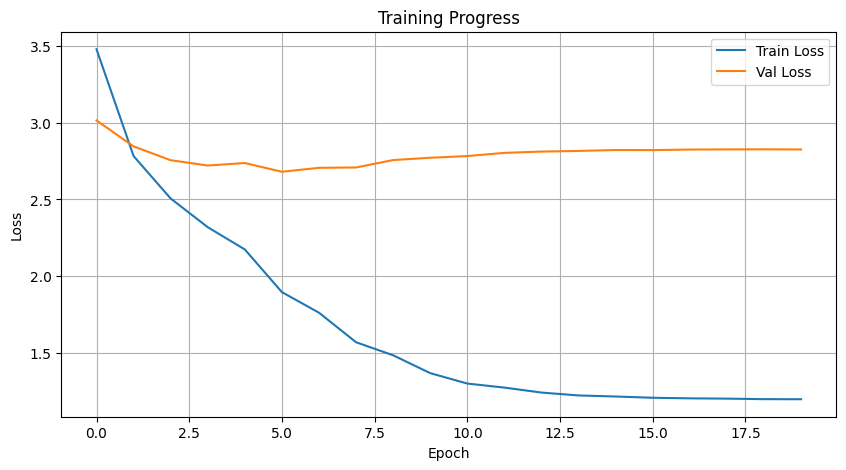

Best validation loss: 2.6805


In [6]:
# 5. Training Loop
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
    return mask

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training")

    for images, captions in progress_bar:
        images = images.to(device)
        captions = captions.to(device)

        # Input is all tokens except last, target is all except first
        tgt_input = captions[:, :-1]
        tgt_output = captions[:, 1:]

        # Create masks
        tgt_seq_len = tgt_input.size(1)
        tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
        tgt_padding_mask = (tgt_input == pad_idx)

        # Forward pass
        optimizer.zero_grad()
        output = model(images, tgt_input, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)

        # Calculate loss
        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in tqdm(loader, desc="Validation"):
            images = images.to(device)
            captions = captions.to(device)

            tgt_input = captions[:, :-1]
            tgt_output = captions[:, 1:]

            tgt_seq_len = tgt_input.size(1)
            tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
            tgt_padding_mask = (tgt_input == pad_idx)

            output = model(images, tgt_input, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))

            total_loss += loss.item()

    return total_loss / len(loader)

# Training
num_epochs = 20
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != current_lr:
       print(f"Learning rate reduced: {current_lr:.2e} → {new_lr:.2e}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'best_model.pth')
        print(f"✓ Best model saved! (Val Loss: {val_loss:.4f})")

print("\nTraining completed!")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {best_val_loss:.4f}")

In [7]:
# 6. Save Model Artifacts
# Save final model artifacts
print("Saving model artifacts...")

# 1. Save complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'config': {
        'vocab_size': vocab_size,
        'embed_dim': 512,
        'num_heads': 8,
        'num_layers': 6,
        'dropout': 0.1
    }
}, 'image_captioning_model_complete.pth')

# 2. Save vocabulary separately
with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# 3. Save training history
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

# 4. Save data splits
with open('data_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("✓ All artifacts saved!")
print("\nSaved files:")
print("  - best_model.pth (best checkpoint)")
print("  - image_captioning_model_complete.pth (final model)")
print("  - vocabulary.pkl")
print("  - training_history.pkl")
print("  - data_splits.pkl")
print("  - training_curves.png")

# Download files (for Colab)
from google.colab import files
print("\nDownloading files...")
files.download('best_model.pth')
files.download('image_captioning_model_complete.pth')
files.download('vocabulary.pkl')
files.download('data_splits.pkl')

Saving model artifacts...
✓ All artifacts saved!

Saved files:
  - best_model.pth (best checkpoint)
  - image_captioning_model_complete.pth (final model)
  - vocabulary.pkl
  - training_history.pkl
  - data_splits.pkl
  - training_curves.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>